## Movie genre classifier: Dataset preparation and model training

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import joblib

import text_wrangling_util
%matplotlib inline

The dataset used in this exercise is "The Movies Dataset" from [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset/version/7#movies_metadata.csv). To reproduce the following, download and unarchive the dataset in the working directory.

In [2]:
data = pd.read_csv("the-movies-dataset/movies_metadata.csv", sep = ',', header = 0, low_memory=False)
movies = data[['title','overview','genres']].copy()
movies.head()

,title,overview,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


### Data wrangling

In [3]:
# Convert dictionaries of genres to lists
def dict_to_list(genres_dict):
    genres_dict = json.loads(genres_dict.replace("\'","\""))
    genres_list = []
    for genre in genres_dict:
        genres_list.append(genre['name'])
    return genres_list

movies['genres'] = movies['genres'].apply(lambda x: dict_to_list(x))

In [4]:
# Discard movies without specified genres
movies_to_discard = (movies['genres'].str.len() == 0)
movies = movies[~movies_to_discard]
print("{} movies without genres were discarded from the dataset".format(sum(movies_to_discard)))

# Discard movies without a title or description
movies_to_discard = (movies.title.isnull() | movies.overview.isnull())
movies = movies[~movies_to_discard]
print("{} movies without title or description were discarded from the dataset".format(sum(movies_to_discard)))
print("----")
print("{} movies remain in the dataset".format(len(movies)))

movies = movies.reset_index(drop=True)

2442 movies without genres were discarded from the dataset
703 movies without title or description were discarded from the dataset
----
42321 movies remain in the dataset


The textual data preprocessing strategy is the following: (1) combine the movie title and description into one body of text, (2) remove apostrophes and other non-alphabetical symbols, (3) set all words to lower case, and (4) perform stemming (see *text_wrangling_util.py* for more details)

In [5]:
# Prepare input text for training
input_text = text_wrangling_util.prepare_input_text(title=list(movies["title"]), description=list(movies["overview"]))

In [6]:
print(input_text[0])
print('-----')
print(input_text[121])

toy stori led woodi andi toy live happili room andi birthday bring buzz lightyear onto scene afraid lose place andi heart woodi plot buzz circumst separ buzz woodi owner duo eventu learn put asid differ
-----
neverend stori iii escap fantasia young boy must restor order group bulli steal magic book act portal earth imaginari world fantasia


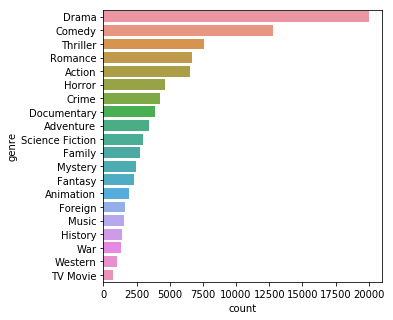

In [7]:
# Frequency distribution of genres
all_genres = [item for sublist in movies["genres"] for item in sublist]
all_genres_distribution = nltk.FreqDist(all_genres) 
all_genres_dist_df = pd.DataFrame({"genre": list(all_genres_distribution.keys()), 
                              "count": list(all_genres_distribution.values())})
all_genres_dist_df = all_genres_dist_df.sort_values("genre")
genres = list(all_genres_dist_df['genre'])

plt.figure(figsize=(5,5)) 
ax = sns.barplot(data=all_genres_dist_df.sort_values("count",ascending=False), x = "count", y = "genre") 
plt.show()

Note that the dataset is quite imbalanced, which in principle should be somehow addressed. That could be done by, e.g., undersampling the overrepresented genres or synthesizing more examples of the underrepresented genres. Here, however, I will try to make do with the original dataset.

### Model training and selection

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import svm

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(movies['genres'])

X_train, X_val, Y_train, Y_val = train_test_split(input_text, Y, test_size=0.2, random_state=0)

vectorizer = Pipeline([('tfidf_vectorizer', TfidfVectorizer(max_df=0.8, max_features=10000))])

In [15]:
pipe_lr = Pipeline([('vectorizer', vectorizer),
                 ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))])

pipe_nb = Pipeline([('vectorizer', vectorizer),
                 ('clf', OneVsRestClassifier(MultinomialNB()))])

pipe_dt = Pipeline([('vectorizer', vectorizer),
                 ('clf', OneVsRestClassifier(tree.DecisionTreeClassifier(max_depth=20)))])

pipelines = [pipe_lr, pipe_nb, pipe_dt]
pipe_dict = {0: 'Logistic Regression', 1: "Multinomial Naive Bayes", 2: 'Decision Tree'}

for i, pipe in enumerate(pipelines):
    print("Fitting model with " + pipe_dict[i] + " classifier...")
    pipe.fit(X_train, Y_train)

Fitting model with Logistic Regression classifier...
Fitting model with Multinomial Naive Bayes classifier...
Fitting model with Decision Tree classifier...


In [16]:
# Find the best threshold value for obtaining classification from model probabilities
def find_best_threshold(pipe, pipe_title, make_plots=True):
    
    Y_pred_prob = pipe.predict_proba(X_val)
    threshold_values = np.linspace(0.1,0.9,17)
    F1_scores = []
    
    for t in threshold_values:
        Y_pred = (Y_pred_prob >= t).astype(int)
        F1_scores.append(f1_score(Y_val, Y_pred, average="micro"))

    max_score = max(F1_scores)
    threshold_value = threshold_values[F1_scores.index(max_score)]
    
    if make_plots:
        F1_vs_threshold = pd.DataFrame({"threshold": threshold_values, "F1": F1_scores})
        plt.figure()
        ax = sns.lineplot(data=F1_vs_threshold, x="threshold", y="F1")
        ax.set(title=pipe_title + ": Best F1-score={} at threshold={}".format(round(max_score,2),threshold_value))
    
    return threshold_value, max(F1_scores)

Best result is with Logistic Regression!


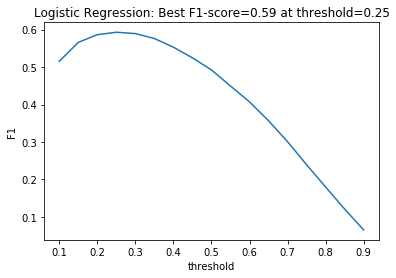

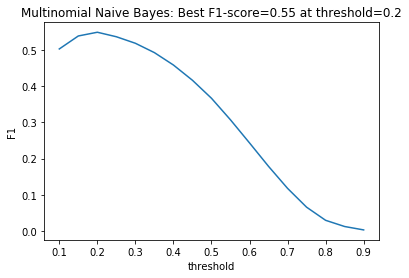

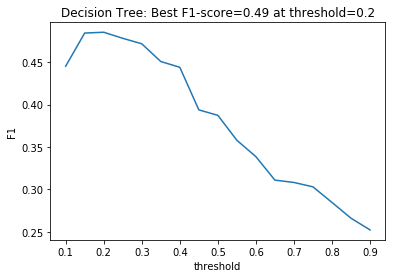

In [30]:
thresholds = []
best_F1_scores = []

for i, pipe in enumerate(pipelines):    
    threshold,F1_score = find_best_threshold(pipe,pipe_dict[i])
    thresholds.append(threshold)
    best_F1_scores.append(F1_score)
 
j = best_F1_scores.index(max(best_F1_scores))
best_pipe = pipelines[j]
best_score = best_F1_scores[j]
threshold_value = thresholds[j]
print("Best result is with {}!".format(pipe_dict[j]))

In [18]:
def infer_genre(title, description):
    
    # Preprocess input
    input_text = text_wrangling_util.prepare_input_text(title, description)
    
    # Inference
    Y_pred_prob = best_pipe.predict_proba(input_text)
    predicted_genres = (Y_pred_prob >= threshold_value).astype(int)
    
    # Visualize the probabilities of the five most likely genres
    pred_prob_df = pd.DataFrame({"genre": genres, "p": Y_pred_prob[0]})
    pred_prob_df = pred_prob_df.sort_values('p',ascending=False)
    plt.figure(figsize=(3,3)) 
    ax = sns.barplot(data=pred_prob_df[0:6], x='p',y='genre')
    ax.set(xlabel='probability')
    
    #return multilabel_binarizer.inverse_transform(predicted_genres)
    return list(pred_prob_df.loc[pred_prob_df["p"] >= threshold_value,"genre"])

In [32]:
# Save the best model
joblib.dump({"pipeline": best_pipe,"threshold": threshold_value,"genres": genres,"score": best_score}, 'movie_genre_classifier.joblib')

['movie_genre_classifier.joblib']

### Some examples

Reimagines the origin and adventures of Sabrina: the Teenage Witch as a dark coming-of-age story that traffics in horror, the occult and, of course, witchcraft. Tonally in the vein of Rosemary's Baby and The Exorcist, this adaptation finds Sabrina Spellman wrestling to reconcile her dual nature - half-witch, half-mortal - while standing against the evil forces that threaten her, her family and the daylight world humans inhabit.
-----
['Horror', 'Fantasy', 'Comedy']


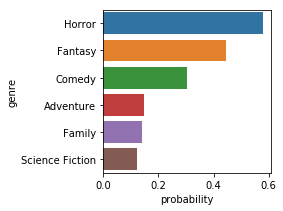

In [20]:
title = "Sabrina: the Teenage Witch"
plot = "Reimagines the origin and adventures of Sabrina: the Teenage Witch as a dark coming-of-age story that traffics in horror, the occult and, of course, witchcraft. Tonally in the vein of Rosemary's Baby and The Exorcist, this adaptation finds Sabrina Spellman wrestling to reconcile her dual nature - half-witch, half-mortal - while standing against the evil forces that threaten her, her family and the daylight world humans inhabit."
print(plot)
print('-----')
print(infer_genre(title, plot))

Told from the perspective of an unseen documentary filmmaker, the series offers an honest, often-hilarious perspective of family life. Parents Phil and Claire yearn for an honest, open relationship with their three kids, but a daughter who is trying to grow up too fast, another who is too smart for her own good, and a rambunctious young son make it challenging. Claire's dad Jay and his Latina wife Gloria are raising two sons together, but people sometimes believe Jay to be Gloria's father. Jay's gay son Mitchell and his partner Cameron have adopted a little Asian girl, completing one big -- straight, gay, multicultural, traditional -- happy family.
-----
['Drama', 'Comedy']


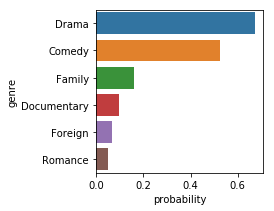

In [21]:
title = "Modern Family"
plot = "Told from the perspective of an unseen documentary filmmaker, the series offers an honest, often-hilarious perspective of family life. Parents Phil and Claire yearn for an honest, open relationship with their three kids, but a daughter who is trying to grow up too fast, another who is too smart for her own good, and a rambunctious young son make it challenging. Claire's dad Jay and his Latina wife Gloria are raising two sons together, but people sometimes believe Jay to be Gloria's father. Jay's gay son Mitchell and his partner Cameron have adopted a little Asian girl, completing one big -- straight, gay, multicultural, traditional -- happy family."
print(plot)
print('-----')
print(infer_genre(title, plot))

This show follows the nights of the detectives working at the Las Vegas Police Department Crime Scene Investigations bureau. Being the second busiest crime lab in America, CSI officers use the best scientific and technical methods to solve puzzles and catch criminals.
-----
['Crime', 'Thriller', 'Action', 'Mystery']


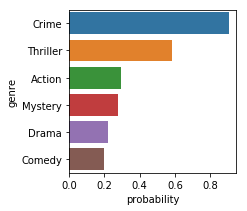

In [22]:
title = "CSI"
plot = "This show follows the nights of the detectives working at the Las Vegas Police Department Crime Scene Investigations bureau. Being the second busiest crime lab in America, CSI officers use the best scientific and technical methods to solve puzzles and catch criminals."
print(plot)
print('-----')
print(infer_genre(title, plot))

The evil Iago pretends to be friend of Othello in order to manipulate him to serve his own end in the film version of this Shakespeare classic.
-----
['Drama', 'Comedy']


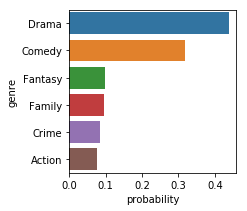

In [23]:
title = "Othello"
plot = "The evil Iago pretends to be friend of Othello in order to manipulate him to serve his own end in the film version of this Shakespeare classic." 
print(plot)
print('-----')
print(infer_genre(title, plot))